In [2]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [3]:
%reload_ext autoreload
%autoreload 2

from video_dataset import VideoDataset

Feature batch shape: torch.Size([8, 1, 29, 64, 64])
Labels batch shape: torch.Size([8])
Labels: tensor([176,  43, 186, 251, 354, 335, 203, 415])


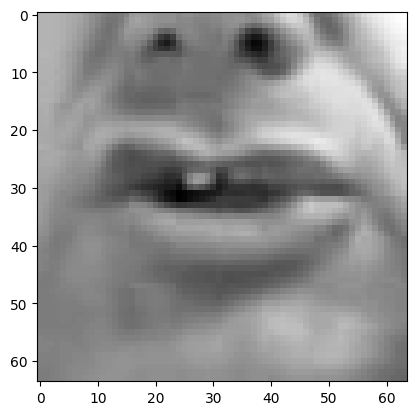

Label: 176


In [4]:
root_dir = 'processed_selected_mp4_files'
dataset = VideoDataset(root_dir=root_dir, mode='train')
test_dataset = VideoDataset(root_dir=root_dir, mode='test')
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Labels: {train_labels}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[10], cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
print(len(test_dataset))
print(len(dataset))

25000
50000


In [6]:
class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def compute_accuracy(output, target):
    correct = 0.0
    total = len(target)
    output = torch.max(output, dim=1).indices
    correct = sum(output == target) 
    acc = correct / total
    return acc

In [8]:
def train(data_loader, model, optimizer, epoch, criterion, device='cpu', batches_per_epoch=100):
    # set the model to training mode
    model.train()

    losses = averageMeter()
    accuracy = averageMeter()
    progress_bar = tqdm(enumerate(data_loader), desc=f"Epoch {epoch} Running", unit="batch", total=batches_per_epoch)    
    for (step, value) in (progress_bar):
      if step >= batches_per_epoch:
        break

      data = value[0].to(device)
      target = value[1].to(device)

      optimizer.zero_grad()

      # forward the data to the model and get the output
      output = model(data)

      # compute accuracy
      acc = compute_accuracy(output, target)
      accuracy.update(acc.item(), data.size(0))

      # compute loss with the output and the target
      loss = criterion(output, target)

      # backward (PyTorch computes backpropagation for you)
      loss.backward()

      optimizer.step()

      # accumulate losses
      losses.update(loss.item(), data.size(0))
      progress_bar.set_postfix({
            'Batch': step + 1,
            'Loss': losses.avg,
            'Accuracy': accuracy.avg
        })

    print(f"[Epoch: {epoch}]\t lr: {optimizer.param_groups[0]['lr']:.4g}\t \
      loss_train: {losses.avg:.4f}\tacc_train: {accuracy.avg:.4f}")
    return losses.avg, accuracy.avg

In [9]:
@torch.no_grad()
def test(data_loader, model, criterion, device='cpu', batches_per_epoch=100):
    # set the model to evaluation mode
    model.eval()

    losses = averageMeter()
    accuracy = averageMeter()
    for (step, value) in enumerate(data_loader):
        if step >= batches_per_epoch:
            break

        data = value[0].to(device)
        target = value[1].to(device)

        # forward the data to the model and get the output
        output = model(data)

        # compute accuracy
        acc = compute_accuracy(output, target)
        accuracy.update(acc.item(), data.size(0))

        # compute loss with the output and the target
        loss = criterion(output, target)

        # accumulate losses
        losses.update(loss.item(), data.size(0))

    return losses.avg, accuracy.avg

In [24]:
class CNN(nn.Module):
    def __init__(self, num_classes=500):
        super(CNN, self).__init__()
        ########### TODO ###########
        # First 3D Convolutional Layer
        self.conv1 = nn.Conv3d(1, 64, kernel_size=(3, 3, 3), padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1)
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=1)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=1)
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=1)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=1)
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=1)
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()

        self.fc6 = nn.Linear(512 * 1 * 2 * 2, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)
        
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)
        x = self.fc8(x)
        
        return x

In [25]:
# unit-test
model = CNN()
print(sum(p.numel() for p in model.parameters()), 'parameters')
x = torch.randn([8, 1, 29, 64, 64]) # simulate Fashion-MNIST images
y = model(x)
print(y.shape)

54874996 parameters
torch.Size([8, 500])


In [27]:
def train_CNN(batch_size=8, lr=0.1, n_epoch=10, eval_epoch=5, batches_per_epoch=1000):

    # setup random seed
    torch.manual_seed(1337)
    torch.cuda.manual_seed(1337)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # setup model
    model = CNN()
    device = 'cpu'
    if torch.cuda.is_available():
        model = model.cuda()
        device = 'cuda'

    # setup data loader
    train_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

    test_loader = DataLoader(
                    test_dataset,
                    batch_size=10,
                    shuffle=False,
                    drop_last=False
                )

    # setup optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    ########### TODO ###########
    # setup loss function (criterion)
    criterion = nn.CrossEntropyLoss()

    ######## End of TODO #######

    # training and evaluation
    losses_train = []
    accs_train = []
    losses_test = []
    accs_test = []
    start_time = time.time()
    for ep in range(n_epoch):
        print(f"running epoch {ep}")

        # train an epoch and get the loss
        loss_train, acc_train = train(train_loader, model, optimizer, ep, criterion, device, batches_per_epoch)
        losses_train.append(loss_train)
        accs_train.append(acc_train)

        if (ep + 1) % eval_epoch == 0:
            # evaluate current model and get the loss
            loss_test, acc_test = test(test_loader, model, criterion, device, batches_per_epoch)
            losses_test.append(loss_test)
            accs_test.append(acc_test)
            print(f'[val]\tloss_test: {loss_test:.4f}\tacc_test: {acc_test:.4f}')
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"epoch runtime: {elapsed:.2f} ")
        start_time = end_time

    # plot the training/testing loss and accuracy
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    ax[0].plot(np.arange(n_epoch), losses_train, color='b', label='train_loss')
    ax[0].plot(np.linspace(0, n_epoch, n_epoch//eval_epoch), losses_test, color='r', label='test_loss')
    ax[0].legend()

    ax[1].plot(np.arange(n_epoch), accs_train, color='b', label='train_acc')
    ax[1].plot(np.linspace(0, n_epoch, n_epoch//eval_epoch), accs_test, color='r', label='test_acc')
    ax[1].legend()

In [28]:
train_CNN()

running epoch 0


Epoch 0 Running:   0%|          | 0/1000 [00:00<?, ?batch/s]

KeyboardInterrupt: 